# 贝叶斯网络

In [1]:
import numpy as np

train_data = np.loadtxt("./data/train.csv", delimiter=",", dtype=np.uint8)
test_data = np.loadtxt("./data/test.csv", delimiter=",", dtype=np.uint8)
pixels_train, labels_train = train_data[:, :-1], train_data[:, -1]
pixels_test, labels_test = test_data[:, :-1], test_data[:, -1]

In [2]:
import numpy as np


class BayesianNetwork:
    def __init__(self, n_labels=10, n_pixels=784, n_values=2) -> None:
        """
        n_labels: number of labels, 10 for digit recognition
        n_pixels: number of pixels, 256 for 16x16 image
        n_values: number of values for each pixel, 0 for black, 1 for white
        """
        self.n_labels = n_labels
        self.n_pixels = n_pixels
        self.n_values = n_values
        # prior probability
        self.labels_prior = np.zeros(n_labels)
        self.pixels_prior = np.zeros((n_pixels, n_values))
        # conditional probability
        self.pixels_cond_label = np.zeros((n_pixels, n_values, n_labels))

    # fit the model with training data
    def fit(self, pixels, labels):
        """
        pixels: (n_samples, n_pixels, )
        labels: (n_samples, )
        """
        n_samples = len(labels)
        # TODO: calculate prior probability and conditional probability
        for i in range(self.n_labels):
            self.labels_prior[i] = np.sum(labels == i) / n_samples
        for i in range(self.n_pixels):
            for j in range(self.n_values):
                for k in range(self.n_labels):
                    self.pixels_cond_label[i][j][k] = np.sum(
                        (pixels[:, i] == j) & (labels == k)
                    ) / np.sum(labels == k)

    # predict the labels for new data
    def predict(self, pixels):
        """
        pixels: (n_samples, n_pixels, )
        return labels: (n_samples, )
        """
        n_samples = len(pixels)
        labels = np.zeros(n_samples)
        # TODO: predict for new data
        for i in range(n_samples):
            p = np.zeros(self.n_labels)
            for j in range(self.n_labels):
                p[j] = self.labels_prior[j]
                for k in range(self.n_pixels):
                    p[j] *= self.pixels_cond_label[k][pixels[i][k]][j]
            labels[i] = np.argmax(p)

        return labels

    # calculate the score (accuracy) of the model
    def score(self, pixels, labels):
        """
        pixels: (n_samples, n_pixels, )
        labels: (n_samples, )
        """
        n_samples = len(labels)
        labels_pred = self.predict(pixels)
        return np.sum(labels_pred == labels) / n_samples

In [3]:
bn = BayesianNetwork()
bn.fit(pixels_train, labels_train)
print("test score: %f" % bn.score(pixels_test, labels_test))

test score: 0.843800


# LeNet5

In [4]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]
)
train_set = datasets.MNIST(
    root="./data", train=True, download=False, transform=transform
)
val_set = datasets.MNIST(
    root="./data", train=False, download=False, transform=transform
)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=10000, shuffle=False, num_workers=0)

In [5]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import tensor


class MyMNIST(Dataset):
    def __init__(self, train) -> None:
        super().__init__()
        if train:
            data = np.loadtxt("./data/train.csv", delimiter=",", dtype=np.float32)
        else:
            data = np.loadtxt("./data/test.csv", delimiter=",", dtype=np.float32)
        self.pixels, self.labels = data[:, :-1], data[:, -1]
        self.pixels = self.pixels.reshape(-1, 1, 28, 28)
        self.pixels = tensor(self.pixels)
        self.labels = tensor(self.labels).long()

    def __getitem__(self, index):
        return self.pixels[index], self.labels[index]

    def __len__(self):
        return len(self.labels)


train_set = MyMNIST(train=True)
val_set = MyMNIST(train=False)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=10000, shuffle=False, num_workers=0)

In [6]:
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor()]
)
train_set = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
val_set = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=10000, shuffle=False, num_workers=0)

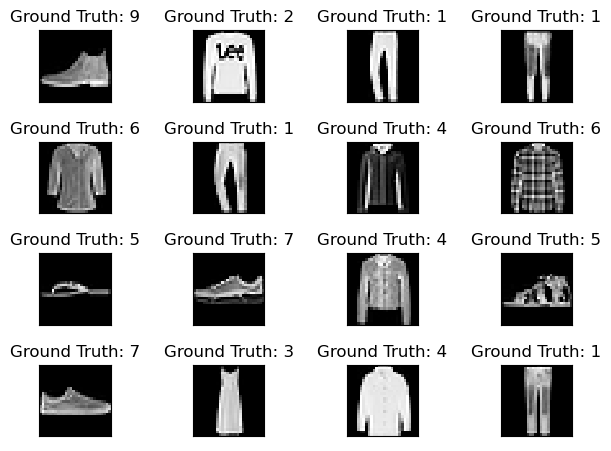

In [7]:
import matplotlib.pyplot as plt

val_data_iter = iter(val_loader)
val_image, val_label = next(val_data_iter)
plt.figure()
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.tight_layout()
    plt.imshow(val_image[i][0], cmap="gray", interpolation="none")
    plt.title("Ground Truth: {}".format(val_label[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
                                    
        x = F.relu(self.conv1(x))         
        x = self.pool1(x)                 
        x = F.relu(self.conv2(x))         
        x = self.pool2(x)                 
        x = x.view(x.size()[0], -1)       
        x = F.relu(self.fc1(x))           
        x = F.relu(self.fc2(x))           
        x = self.fc3(x)                   
        return x

In [9]:
import torch
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
net = LeNet()
net.to(device)
summary(net, input_size=(1, 28, 28), device="cuda")

using cuda device.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
         MaxPool2d-2            [-1, 6, 12, 12]               0
            Conv2d-3             [-1, 16, 8, 8]           2,416
         MaxPool2d-4             [-1, 16, 4, 4]               0
            Linear-5                  [-1, 120]          30,840
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 44,426
Trainable params: 44,426
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.17
Estimated Total Size (MB): 0.22
----------------------------------------------------------------


  0%|          | 0/5 [00:00<?, ?it/s]

Step: 1500 Train_loss: 0.301 Acc: 8778/10000(88%): 100%|██████████| 5/5 [01:27<00:00, 17.52s/it]


Finished Training


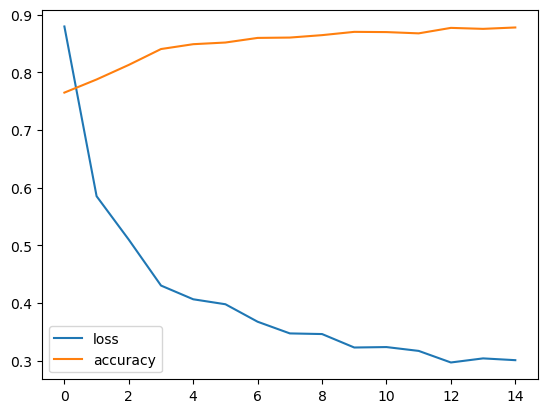

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
tr_loss = []
val_acc = []
progress_bar = tqdm(range(5))

for iter in progress_bar:
    running_loss = 0.0
    for step, data in enumerate(train_loader, start=0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % 500 == 499:
            with torch.no_grad():
                outputs = net(val_image.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                accuracy = torch.eq(
                    predict_y, val_label.to(device)
                ).sum().item() / val_label.size(0)
                tr_loss.append(running_loss / 500)
                val_acc.append(accuracy)
                progress_bar.set_description(
                    "Step: %d Train_loss: %.3f Acc: %d/%d(%.0f%%)"
                    % (
                        step + 1,
                        running_loss / 500,
                        torch.eq(predict_y, val_label.to(device)).sum().item(),
                        val_label.size(0),
                        100.0 * accuracy,
                    )
                )
                running_loss = 0.0

print("Finished Training")
plt.plot(tr_loss, label="loss")
plt.plot(val_acc, label="accuracy")
plt.legend()
plt.show()

In [71]:
import torch
import matplotlib.pyplot as plt
import time

net = LeNet()
net.load_state_dict(torch.load('./model.pth'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

start = time.time()
with torch.no_grad():
    output = net(val_image.to(device))
end = time.time()
print("Time: %.4f s" % (end - start))

output = torch.max(output, dim=1)[1]
cmp = torch.eq(output, val_label.to(device)).to("cpu")
accuracy = cmp.sum().item() / val_label.size(0)
print("Accuracy: %.4f" % accuracy)
# error_data = val_image[cmp == False]
# error_label  = val_label[cmp == False]
# error_output = output[cmp == False]
# plt.figure(figsize=(10,10))
# for i in range(16):
#     plt.subplot(4, 4, i + 1)
#     plt.tight_layout()
#     plt.imshow(error_data[i][0], cmap="gray", interpolation="none")
#     plt.title("Prediction: {}, Ground Truth: {}".format(error_label[i], error_output[i]))
#     plt.xticks([])
#     plt.yticks([])
# plt.show()

Time: 0.0162 s
Accuracy: 0.8983


In [ ]:
import numpy as np
for name, param in net.named_parameters():
    np.savetxt(f'./weight2/{name}.txt', param.cpu().detach().numpy().flatten())